In [7]:
import gc
import os

# import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import wandb

from PIL import Image
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model, list_models
from timm.data import create_transform
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [8]:
plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

In [9]:
# Common
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

os.environ["WANDB_MODE"] = "online"
if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")

RSNA_2022_PATH = '../input/rsna-breast-cancer-detection'
TRAIN_IMAGES_PATH = f'/kaggle/input/rsna-cut-off-empty-space-from-images'
MAX_TRAIN_BATCHES = 40000
MAX_EVAL_BATCHES = 400
MODELS_PATH = '/kaggle/input/wandb-models/models'
NUM_WORKERS = 8
PREDICT_MAX_BATCHES = 1e9
N_FOLDS = 2
FOLDS = np.array(os.environ.get('FOLDS', '0,1').split(',')).astype(int)
WANDB_SWEEP_PROJECT = 'rsna-breast-cancer-sweeps'
WANDB_PROJECT = 'RSNA-breast-cancer-v4'

CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id', 'age']
TARGET = 'cancer'
ALL_FEAT = [TARGET] + CATEGORY_AUX_TARGETS

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = '..'
    TRAIN_IMAGES_PATH = '../Image_2048'
    MODELS_PATH = '../models_2048_effnetb2_r2'
    os.environ['WANDB_API_KEY'] = 'f9429ad0b47cd358cecced15639c23efd26569e8'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Running locally


In [10]:
# Switchers
DEBUG = True
WANDB_SWEEP = False
TRAIN = True
CV = True

In [11]:
# Config

class Config:
    # These are optimal parameters collected from https://wandb.ai/vslaykovsky/rsna-breast-cancer-sweeps/sweeps/k281hlr9?workspace=user-vslaykovsky
    ONE_CYCLE = True
    ONE_CYCLE_PCT_START = 0.1
    ADAMW = False
    ADAMW_DECAY = 0.024
    # ONE_CYCLE_MAX_LR = float(os.environ.get('LR', '0.0008'))
    ONE_CYCLE_MAX_LR = float(os.environ.get('LR', '0.0004'))
    EPOCHS = int(os.environ.get('EPOCHS', 3))
    MODEL_TYPE = os.environ.get('MODEL', 'efficientnet_b2')
    DROPOUT = float(os.environ.get('DROPOUT', 0.0))
    AUG = os.environ.get('AUG', 'true').lower() == 'true'
    AUX_LOSS_WEIGHT = 94
    POSITIVE_TARGET_WEIGHT=20
    # BATCH_SIZE = 32
    BATCH_SIZE = 2
    AUTO_AUG_M = 10
    AUTO_AUG_N = 2
    TTA = False


WANDB_RUN_NAME = f'{Config.MODEL_TYPE}_lr{Config.ONE_CYCLE_MAX_LR}_ep{Config.EPOCHS}_bs{Config.BATCH_SIZE}_pw{Config.POSITIVE_TARGET_WEIGHT}_' +\
f'aux{Config.AUX_LOSS_WEIGHT}_{"adamw" if Config.ADAMW else "adam"}_{"aug" if Config.AUG else "noaug"}_drop{Config.DROPOUT}'
print('run', WANDB_RUN_NAME, 'folds', FOLDS)


run efficientnet_b2_lr0.0004_ep3_bs2_pw20_aux94_adam_aug_drop0.0 folds [0 1]


In [12]:
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [13]:
from sklearn.model_selection import StratifiedGroupKFold

split = StratifiedGroupKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, df_train.cancer, groups=df_train.patient_id)):
    df_train.loc[test_idx, 'split'] = k
df_train.split = df_train.split.astype(int)
df_train.groupby('split').cancer.mean()

split
0    0.021126
1    0.021210
Name: cancer, dtype: float64

In [14]:
df_train.age.fillna(df_train.age.mean(), inplace=True)
df_train['age'] = pd.qcut(df_train.age, 10, labels=range(10), retbins=False).astype(int)
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,split
0,2,10006,462822612,L,CC,5,0,0,0,NaN,0,NaN,29,False,1
1,2,10006,1459541791,L,MLO,5,0,0,0,NaN,0,NaN,29,False,1
2,2,10006,1864590858,R,MLO,5,0,0,0,NaN,0,NaN,29,False,1
3,2,10006,1874946579,R,CC,5,0,0,0,NaN,0,NaN,29,False,1
4,2,10011,220375232,L,CC,3,0,0,0,0.0,0,NaN,21,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,0,0,0,0,1.0,0,C,49,False,1
54702,1,9989,63473691,L,MLO,5,0,0,0,NaN,0,C,216,False,0
54703,1,9989,1078943060,L,CC,5,0,0,0,NaN,0,C,216,False,0
54704,1,9989,398038886,R,MLO,5,0,0,0,0.0,0,C,216,True,0


In [15]:
df_train[CATEGORY_AUX_TARGETS] = df_train[CATEGORY_AUX_TARGETS].apply(LabelEncoder().fit_transform)
df_train[ALL_FEAT]

,cancer,site_id,laterality,view,implant,biopsy,invasive,BIRADS,density,difficult_negative_case,machine_id,age
0,0,1,0,1,0,0,0,3,4,0,1,5
1,0,1,0,5,0,0,0,3,4,0,1,5
2,0,1,1,5,0,0,0,3,4,0,1,5
3,0,1,1,1,0,0,0,3,4,0,1,5
4,0,1,0,1,0,0,0,0,4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
54701,0,0,1,5,0,0,0,1,2,0,3,0
54702,0,0,0,5,0,0,0,3,2,0,9,5
54703,0,0,0,1,0,0,0,3,2,0,9,5
54704,0,0,1,5,0,0,0,0,2,1,9,5


(558, 2038)


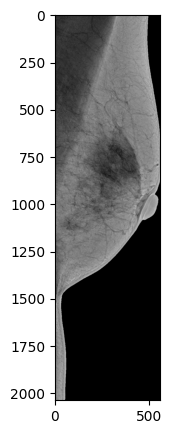

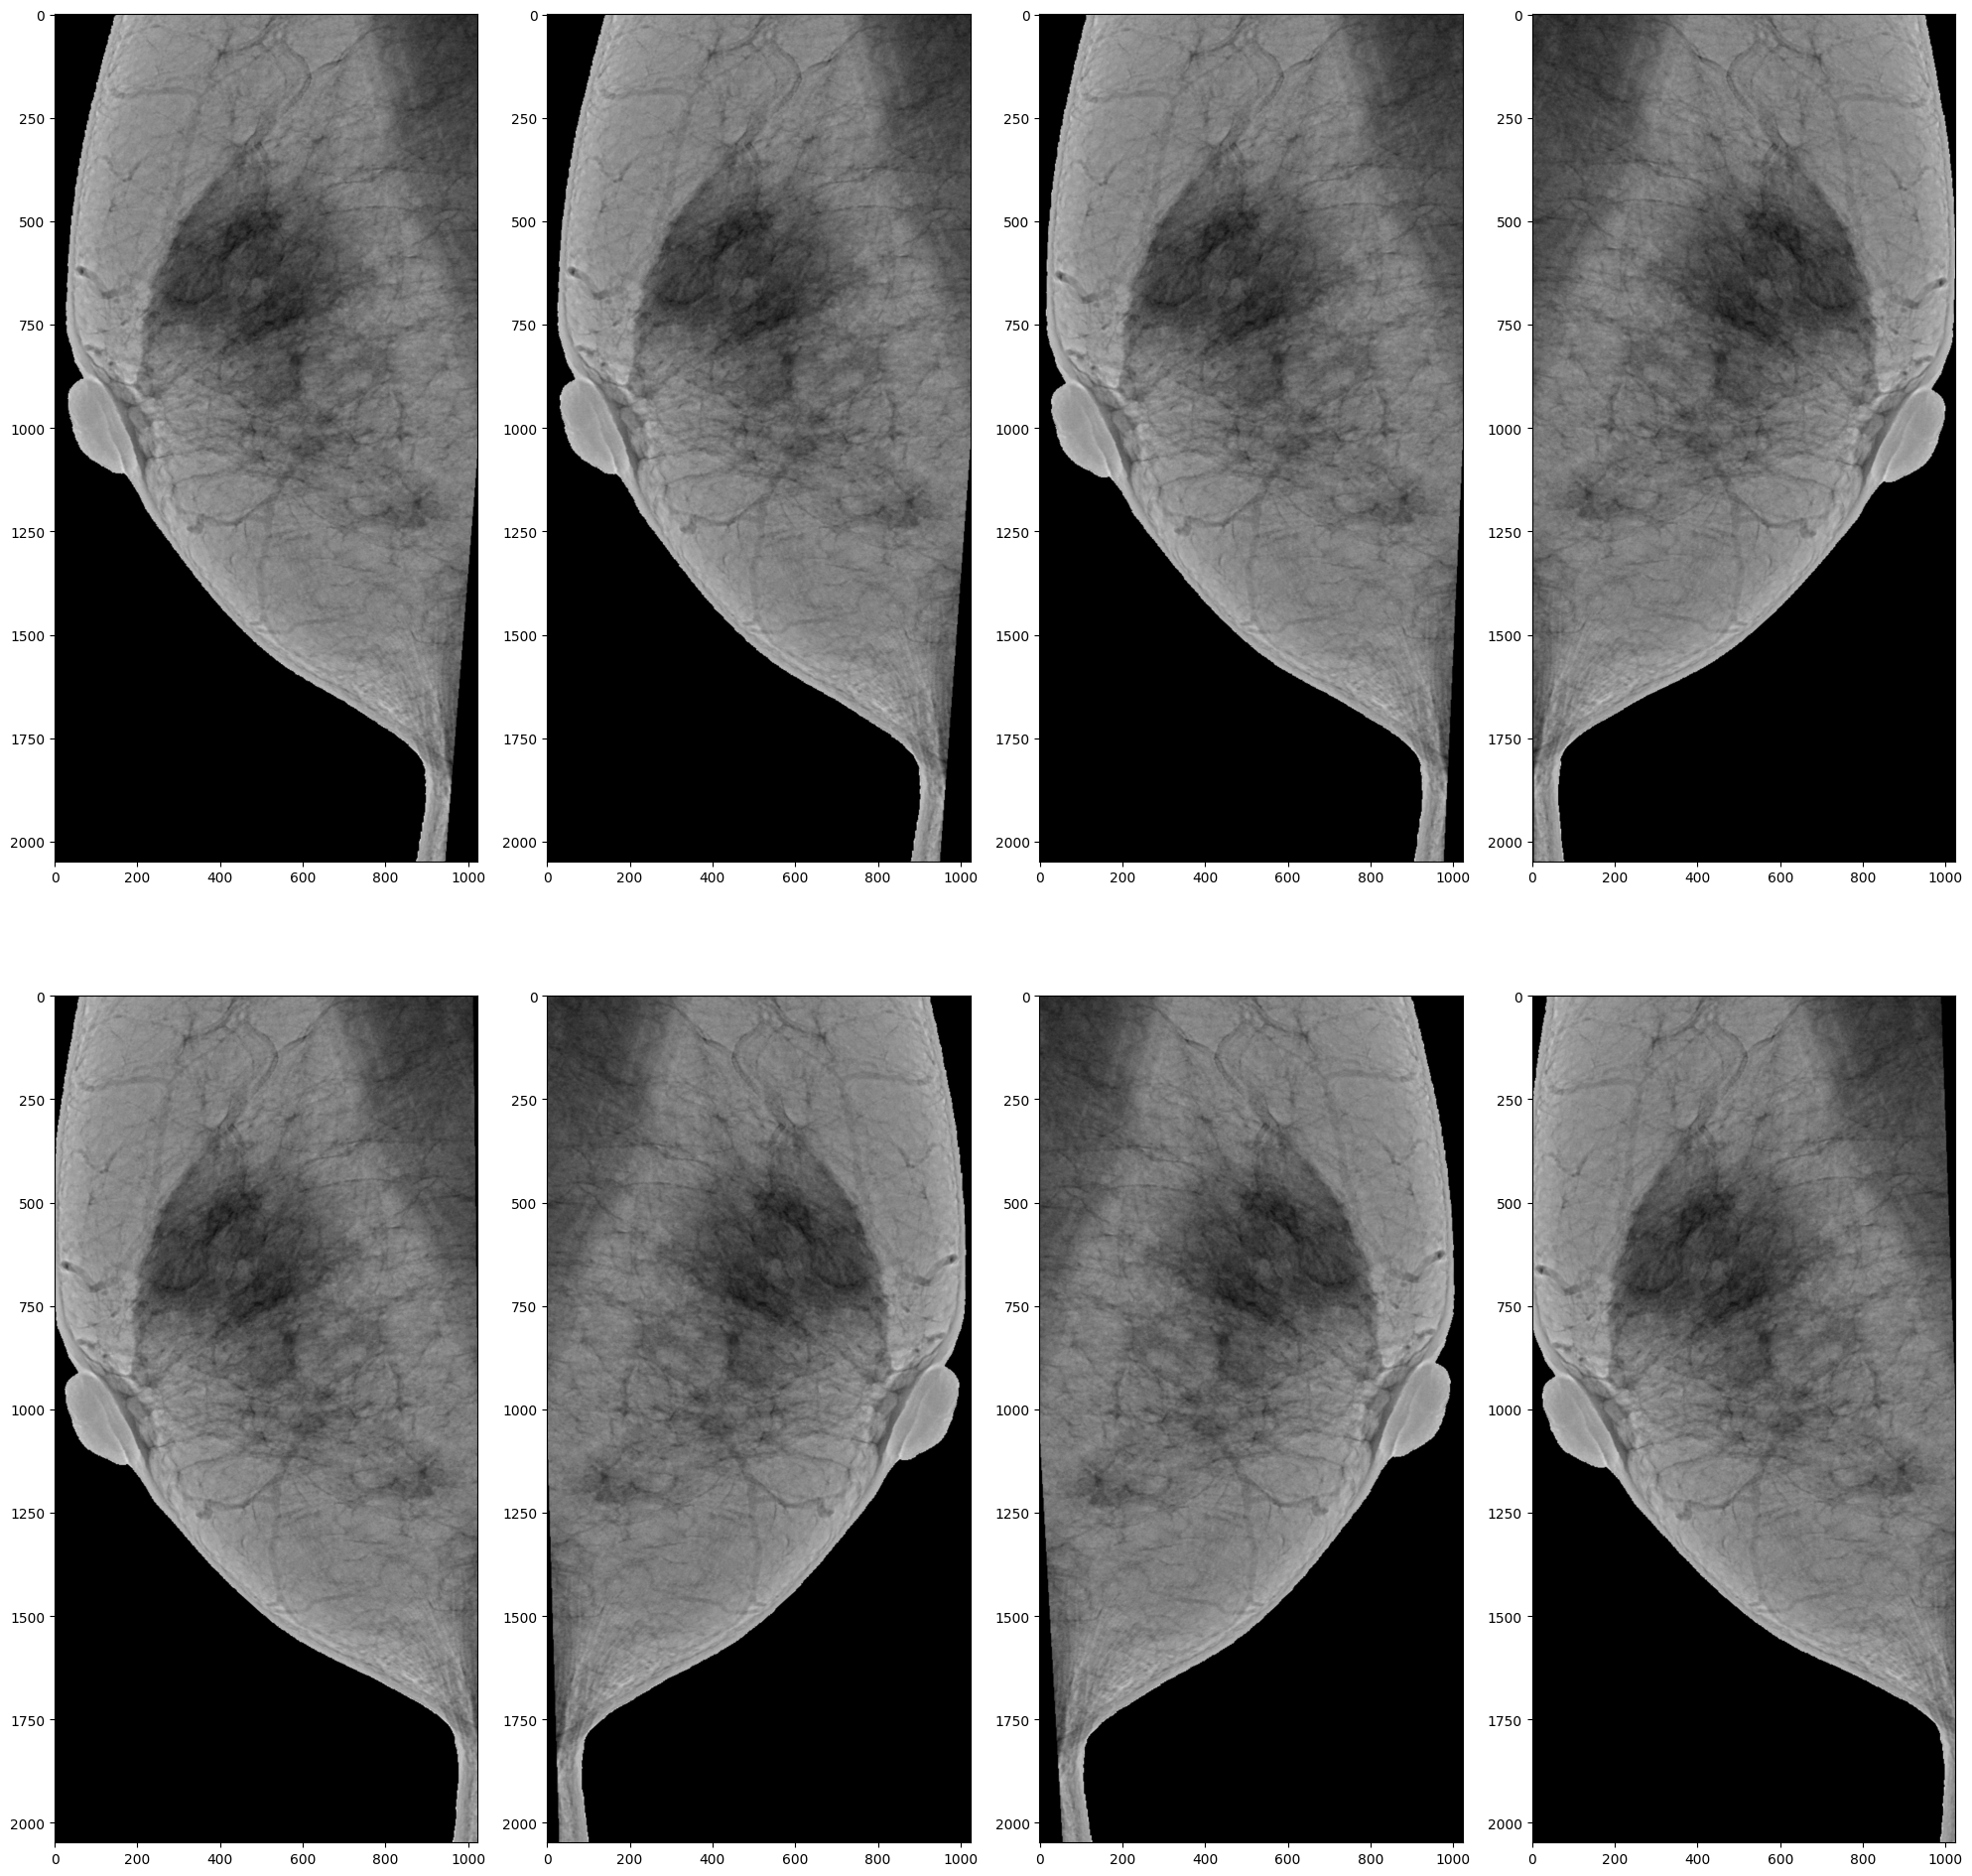

In [16]:
import torchvision

def get_transforms(aug=False):
    """
    # old transforms
    create_transform(
        (1024, 512), 
        mean=0.53, #(0.53, 0.53, 0.53),
        std=0.23, #(0.23, 0.23, 0.23),
        is_training=is_training, 
        auto_augment=f'rand-m{config.AUTO_AUG_M}-n{config.AUTO_AUG_N}'
    )
    """
    def transforms(img):
        img = img.convert('RGB')#.resize((512, 512))
        if aug:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
                torchvision.transforms.RandomResizedCrop((2048, 1024), scale=(0.8, 1), ratio=(0.45, 0.55)) 
            ]
        else:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.Resize((2048, 1024))
            ]
        img = torchvision.transforms.Compose(tfm + [            
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.2179, std=0.0529),
            
        ])(img)
        return img

    return lambda img: transforms(img)

if DEBUG:
    tfm = get_transforms(aug=True)
    img = Image.open(f"{TRAIN_IMAGES_PATH}/10006/1459541791.png")
    print(img.size)
    plt.imshow(np.array(img), cmap='gray')
    plt.show()

    plt.figure(figsize=(20, 20))
    for i in range(8):
        v = tfm(img).permute(1, 2, 0)
        v -= v.min()
        v /= v.max()
        # plt.imshow(v)
        # break
        plt.subplot(2, 4, i + 1).imshow(v)
    plt.tight_layout()

In [17]:
class BreastCancerDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):

        path = f'{self.path}/{self.df.iloc[i].patient_id}/{self.df.iloc[i].image_id}.png'
        try:
            img = Image.open(path).convert('RGB')
        except Exception as ex:
            print(path, ex)
            return None

        if self.transforms is not None:
            img = self.transforms(img)


        if TARGET in self.df.columns:
            cancer_target = torch.as_tensor(self.df.iloc[i].cancer)
            cat_aux_targets = torch.as_tensor(self.df.iloc[i][CATEGORY_AUX_TARGETS])
            return img, cancer_target, cat_aux_targets

        return img

    def __len__(self):
        return len(self.df)

In [18]:
ds_train = BreastCancerDataSet(df_train, TRAIN_IMAGES_PATH, get_transforms(aug=True))
if DEBUG:
    X, y_cancer, y_aux = ds_train[42]
    print(X.shape, y_cancer.shape, y_aux.shape)

torch.Size([3, 2048, 1024]) torch.Size([]) torch.Size([11])


In [19]:
class BreastCancerModel(torch.nn.Module):
    def __init__(self, aux_classes, model_type=Config.MODEL_TYPE, dropout=0.):
        super().__init__()
        self.model = create_model(model_type, pretrained=True, num_classes=0, drop_rate=dropout)

        self.backbone_dim = self.model(torch.randn(1, 3, 512, 512)).shape[-1]

        self.nn_cancer = torch.nn.Sequential(
            torch.nn.Linear(self.backbone_dim, 1),
        )
        self.nn_aux = torch.nn.ModuleList([
            torch.nn.Linear(self.backbone_dim, n) for n in aux_classes
        ])

    def forward(self, x):
        # returns logits
        x = self.model(x)

        cancer = self.nn_cancer(x).squeeze()
        aux = []
        for nn in self.nn_aux:
            aux.append(nn(x).squeeze())
        return cancer, aux

    def predict(self, x):
        cancer, aux = self.forward(x)
        sigaux = []
        for a in aux:
            sigaux.append(torch.softmax(a, dim=-1))
        return torch.sigmoid(cancer), sigaux

AUX_TARGET_NCLASSES = df_train[CATEGORY_AUX_TARGETS].max() + 1

if DEBUG:
    with torch.no_grad():
        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='seresnext50_32x4d')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('seresnext', pred.shape, len(aux))

        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnet_b4')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('efficientnet_b4', pred.shape, len(aux))

    del model

seresnext torch.Size([2]) 11
efficientnet_b4 torch.Size([2]) 11


In [20]:
def save_model(name, model, thres, model_type):
    torch.save({'model': model.state_dict(), 'threshold': thres, 'model_type': model_type}, f'{name}')
    
def load_model(name, dir='.', model=None):
    data = torch.load(os.path.join(dir, f'{name}'), map_location=DEVICE)
    if model is None:
        model = BreastCancerModel(AUX_TARGET_NCLASSES, data['model_type'])
    model.load_state_dict(data['model'])
    return model, data['threshold'], data['model_type']


if DEBUG:
    # quick test
    model = torch.nn.Linear(2, 1)
    save_model('testmodel', model, thres=0.123, model_type='abc')

    model1, thres, model_type = load_model('testmodel', model=torch.nn.Linear(2, 1))
    assert torch.all(
        next(iter(model1.parameters())) == next(iter(model.parameters()))
    ).item(), "Loading/saving is inconsistent!"
    print(thres, model_type)

0.123 abc


In [21]:
def pfbeta(labels, predictions, beta=1.):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / max(y_true_count, 1)  # avoid / 0
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def optimal_f1(labels, predictions):
    thres = np.linspace(0, 1, 101)
    f1s = [pfbeta(labels, predictions > thr) for thr in thres]
    idx = np.argmax(f1s)
    return f1s[idx], thres[idx]

def evaluate_model(model: BreastCancerModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False, config=Config):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=config.BATCH_SIZE, shuffle=shuffle, num_workers=NUM_WORKERS, pin_memory=False)
    pred_cancer = []
    with torch.no_grad():
        
        model.eval()
        cancer_losses = []
        aux_losses = []
        losses = []
        targets = []
        with tqdm(dl_test, desc='Eval', mininterval=30) as progress:
            for i, (X, y_cancer, y_aux) in enumerate(progress):
                with autocast(enabled=True):
                    y_aux = y_aux.to(DEVICE)
                    X = X.to(DEVICE)
                    y_cancer_pred, aux_pred = model.forward(X)
                    if config.TTA:
                        y_cancer_pred2, aux_pred2 = model.forward(torch.flip(X, dims=[-1])) # horizontal mirror
                        y_cancer_pred = (y_cancer_pred + y_cancer_pred2) / 2
                        aux_pred = [(v1 + v2) / 2 for v1, v2 in zip(aux_pred, aux_pred2)]

                    cancer_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                        y_cancer_pred, 
                        y_cancer.to(float).to(DEVICE),
                        pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
                    ).item()
                    aux_loss = torch.mean(torch.stack([torch.nn.functional.cross_entropy(aux_pred[i], y_aux[:, i]) for i in range(y_aux.shape[-1])])).item()
                    pred_cancer.append(torch.sigmoid(y_cancer_pred))
                    cancer_losses.append(cancer_loss)
                    aux_losses.append(aux_loss)
                    losses.append(cancer_loss + config.AUX_LOSS_WEIGHT * aux_loss)
                    targets.append(y_cancer.cpu().numpy())
                if i >= max_batches:
                    break
        targets = np.concatenate(targets)
        pred = torch.concat(pred_cancer).cpu().numpy()
        pf1, thres = optimal_f1(targets, pred)
        return np.mean(cancer_losses), (pf1, thres), pred, np.mean(losses), np.mean(aux_losses)


# quick test
if DEBUG:

    m = BreastCancerModel(AUX_TARGET_NCLASSES)
    closs, f1, pred, loss, aloss = evaluate_model(m, ds_train, max_batches=2)
    del m
    closs, f1, pred.shape, loss, aloss

Eval:   0%|          | 2/27353 [00:03<12:40:00,  1.67s/it]
/tmp/ipykernel_10970/1030292389.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c_precision = ctp / (ctp + cfp)


In [22]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()
    # torch.cuda.clear_memory_allocated()

def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

def train_model(ds_train, ds_eval, logger, name, config=Config, do_save_model=True):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    model = BreastCancerModel(AUX_TARGET_NCLASSES, config.MODEL_TYPE, config.DROPOUT).to(DEVICE)

    if config.ADAMW:
        optim = torch.optim.AdamW(add_weight_decay(model, weight_decay=config.ADAMW_DECAY, skip_list=['bias']), lr=config.ONE_CYCLE_MAX_LR, betas=(0.9, 0.999), weight_decay=config.ADAMW_DECAY)
    else:
        optim = torch.optim.Adam(model.parameters())


    scheduler = None
    if config.ONE_CYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=config.ONE_CYCLE_MAX_LR, epochs=config.EPOCHS,
                                                        steps_per_epoch=len(dl_train),
                                                        pct_start=config.ONE_CYCLE_PCT_START)
        
    

    scaler = GradScaler()
    best_eval_score = 0
    for epoch in tqdm(range(config.EPOCHS), desc='Epoch'):

        model.train()
        with tqdm(dl_train, desc='Train', mininterval=30) as train_progress:
            for batch_idx, (X, y_cancer, y_aux) in enumerate(train_progress):
                y_aux = y_aux.to(DEVICE)

                optim.zero_grad()
                # Using mixed precision training
                with autocast():
                    #try:
                        y_cancer_pred, aux_pred = model.forward(X.to(DEVICE))
                        cancer_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                            y_cancer_pred,
                            y_cancer.float().to(DEVICE),
                            pos_weight=torch.tensor([config.POSITIVE_TARGET_WEIGHT]).to(DEVICE)
                        )
                        aux_loss = torch.mean(torch.stack([torch.nn.functional.cross_entropy(aux_pred[i], y_aux[:, i]) for i in range(y_aux.shape[-1])]))
                        loss = cancer_loss + config.AUX_LOSS_WEIGHT * aux_loss
                        if np.isinf(loss.item()) or np.isnan(loss.item()):
                            print(f'Bad loss, skipping the batch {batch_idx}')
                            del loss, cancer_loss, y_cancer_pred
                            gc_collect()
                            continue
                    #except:
                    #    print(f'Bad loss, skipping the batch {batch_idx}')
                    #    gc_collect()
                    #    continue

                # scaler is needed to prevent "gradient underflow"
                scaler.scale(loss).backward()
                scaler.step(optim)
                if scheduler is not None:
                    scheduler.step()
                    
                scaler.update()

                lr = scheduler.get_last_lr()[0] if scheduler else config.ONE_CYCLE_MAX_LR
                logger.log({'loss': (loss.item()),
                            'cancer_loss': cancer_loss.item(),
                            'aux_loss': aux_loss.item(),
                            'lr': lr,
                            'epoch': epoch})


        if ds_eval is not None and MAX_EVAL_BATCHES > 0:
            cancer_loss, (f1, thres), _, loss, aux_loss = evaluate_model(
                model, ds_eval, max_batches=MAX_EVAL_BATCHES, shuffle=False, config=config)

            if f1 > best_eval_score:
                best_eval_score = f1
                if do_save_model:
                    save_model(name, model, thres, config.MODEL_TYPE)
                    art = wandb.Artifact("rsna-breast-cancer", type="model")
                    art.add_file(f'{name}')
                    logger.log_artifact(art)

            logger.log(
                {
                    'eval_cancer_loss': cancer_loss,
                    'eval_f1': f1,
                    'max_eval_f1': best_eval_score,
                    'eval_f1_thres': thres,
                    'eval_loss': loss,
                    'eval_aux_loss': aux_loss,
                    'epoch': epoch
                }
            )

    return model


# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.



In [17]:

if TRAIN:
    for fold in FOLDS:
         name = f'{WANDB_RUN_NAME}-f{fold}'
         with wandb.init(project=WANDB_PROJECT, name=name, group=WANDB_RUN_NAME) as run:
            gc_collect()
            ds_train = BreastCancerDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=Config.AUG))
            ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))
            train_model(ds_train, ds_eval, run, f'model-f{fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xiaosuhu86. Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/home/frank/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Eval:   3%|▎         | 400/13680 [00:21<11:59, 18.46it/s]
/tmp/ipykernel_2908/1030292389.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c_precision = ctp / (ctp + cfp)
Epoch: 100%|██████████| 3/3 [1:30:55<00:00, 1818.46s/it]


aux_loss,▆▅▆▃▇▅█▃▆▂▄▁▇▃▄▅▅▂▄▃▂▁▂▂▃▃▂▂▄▂▂▄▅▂▂▃▆▂▄▄
cancer_loss,▁▁▁▁▁▁▁▁▇▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
eval_aux_loss,▁▃█
eval_cancer_loss,▆█▁
eval_f1,█▁▃
eval_f1_thres,▁█▄
eval_loss,▁▃█
loss,▆▅▇▃▇▅█▃▇▂▄▁█▃▄▅▅▂▄▃▂▁▂▂▃▃▂▂▄▂▂▄▅▂▃▃▆▂▅▄
lr,▂▃▆███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
max_eval_f1,▁▁▁


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/home/frank/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Eval:   3%|▎         | 400/13673 [00:21<12:08, 18.22it/s]
/tmp/ipykernel_2908/1030292389.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c_precision = ctp / (ctp + cfp)
Epoch: 100%|██████████| 3/3 [1:31:20<00:00, 1826.80s/it]


aux_loss,▄▄▅▆▄▄▆▅▄▅▃▄▃▂▆▅▆▄▁▄▃▂█▃▁▂▂▂▃▂▃▂▁▄▅▁▃▁▃▂
cancer_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
eval_aux_loss,█▁▃
eval_cancer_loss,█▅▁
eval_f1,▁▇█
eval_f1_thres,▁█▇
eval_loss,█▁▃
loss,▃▄▄▅▃▄▅▄▃▄▃▄▃▂▅▄▅▃▁▃▃▂█▃▁▁▂▂▃▁▃▁▁▄▄▁▃▁▃▂
lr,▂▃▆███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
max_eval_f1,▁▇█


In [18]:
if WANDB_SWEEP:
    sweep_id = os.environ.get('SWEEP_ID')
    print('wandb sweep ', sweep_id)

    if sweep_id is None:
        """
        First run. Generate sweep_id.
        """
        sweep_id = wandb.sweep(sweep={
            'method': 'bayes',
            'name': 'rsna-sweep',
            'metric': {'goal': 'maximize', 'name': 'max_eval_f1'},
            'parameters':
                {
                    'ONE_CYCLE': {'values': [True, False]},
                    'ONE_CYCLE_PCT_START': {'values': [0.1]},
                    'ADAMW': {'values': [True, False]},
                    'ADAMW_DECAY': {'min': 0.001, 'max': 0.1, 'distribution': 'log_uniform_values'},
                    'ONE_CYCLE_MAX_LR': {'min': 1e-5, 'max': 1e-3, 'distribution': 'log_uniform_values'},
                    'EPOCHS': {'min': 1, 'max': 12, 'distribution': 'q_log_uniform_values'},
                    'MODEL_TYPE': {'values': ['resnext50_32x4d', 'efficientnetv2_rw_s', 'seresnext50_32x4d', 'inception_v4', 'efficientnet_b4']},
                    'DROPOUT': {'values': [0., 0.2]},
                    'AUG': {'values': [True, False]},
                    'AUX_LOSS_WEIGHT': {'min': 0.01, 'max': 100., 'distribution': 'log_uniform_values'},
                    'POSITIVE_TARGET_WEIGHT': {'min': 1., 'max': 60., 'distribution': 'uniform'},
                    'BATCH_SIZE': {'values': [32]},
                    'AUTO_AUG_M': {'min': 1, 'max': 20, 'distribution': 'q_log_uniform_values'},
                    'AUTO_AUG_N': {'min': 1, 'max': 6, 'distribution': 'q_uniform'},
                    'TTA': {'values': [False]},
                }
        }, project=WANDB_SWEEP_PROJECT)
        print('Generated sweep id', sweep_id)
    else:
        """
        Agent run. Use sweep_id generated above to produce (semi)-random hyperparameters run.config
        """
        def wandb_callback():
            with wandb.init() as run:
                print('params', run.config)
                fold = 0
                ds_train = BreastCancerDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=run.config.AUG))
                ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))
                train_model(ds_train, ds_eval, run, f'model-f{fold}', config=run.config, do_save_model=False)


        # Start sweep job.
        wandb.agent(sweep_id, project=WANDB_SWEEP_PROJECT, function=wandb_callback, count=100000)

In [23]:
models = [load_model(model, MODELS_PATH, BreastCancerModel(AUX_TARGET_NCLASSES))[0] for model in sorted(os.listdir(MODELS_PATH))]
models

[BreastCancerModel(
   (model): EfficientNet(
     (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNormAct2d(
       32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
       (drop): Identity()
       (act): SiLU(inplace=True)
     )
     (blocks): Sequential(
       (0): Sequential(
         (0): DepthwiseSeparableConv(
           (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (bn1): BatchNormAct2d(
             32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
             (drop): Identity()
             (act): SiLU(inplace=True)
           )
           (se): SqueezeExcite(
             (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (act1): SiLU(inplace=True)
             (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (gate): Sigmoid()
           )
           (conv_pw): C

In [24]:
def gen_predictions(models, df_train):
    df_train_predictions = []
    with tqdm(enumerate(models), total=len(models), desc='Folds') as progress:
        for fold, model in progress:
            if model is not None:
                ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))

                cancer_loss, (f1, thres), pred_cancer = evaluate_model(model, ds_eval, PREDICT_MAX_BATCHES)[:3]
                progress.set_description(f'Eval fold:{fold} pF1:{f1:.02f}')
                df_pred = pd.DataFrame(data=pred_cancer,
                                              columns=['cancer_pred_proba'])
                df_pred['cancer_pred'] = df_pred.cancer_pred_proba > thres

                df = pd.concat(
                    [df_train.query('split == @fold').reset_index(drop=True), df_pred],
                    axis=1
                ).sort_values(['patient_id', 'image_id'])
                df_train_predictions.append(df)
    df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

if CV:
    models = [load_model(model, MODELS_PATH, BreastCancerModel(AUX_TARGET_NCLASSES))[0] for model in sorted(os.listdir(MODELS_PATH))]
    df_pred = gen_predictions(models, df_train)
    df_pred.to_csv('train_predictions.csv', index=False)
    !head train_predictions.csv

Folds:   0%|          | 0/2 [07:13<?, ?it/s]


RuntimeError: Too many open files. Communication with the workers is no longer possible. Please increase the limit using `ulimit -n` in the shell or change the sharing strategy by calling `torch.multiprocessing.set_sharing_strategy('file_system')` at the beginning of your code

In [25]:
if CV:
    df_pred = pd.read_csv('train_predictions.csv')
    print('F1 CV score (multiple thresholds):', sklearn.metrics.f1_score(df_pred.cancer, df_pred.cancer_pred))    
    df_pred = df_pred.groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    print('pF1 CV score. Mean aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_mean.values))
    print('pF1 CV score. Max aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_max.values))

F1 CV score (multiple thresholds): 0.177227251071939


/tmp/ipykernel_10970/1030292389.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c_precision = ctp / (ctp + cfp)


pF1 CV score. Mean aggregation, single threshold: (0.20417633410672856, 0.6)
pF1 CV score. Max aggregation, single threshold: (0.22850412249705535, 0.8)
